In [6]:
import os
import sys
sys.path.append("../")
import tensorflow as tf
from glob import glob
from typing import List
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy.config import params
from rosbag2numpy.config import generalization_model_params as g_params
from rosbag2numpy.data_processing.data_loader_fv import dataset_loader
import time
import os

print(tf.__version__)


2.3.0


In [20]:
ds_loader = dataset_loader(
    tfrec_dir=params.get("dataset_dir"),
    batch_size=32,
    shuffle_buffer=3200,
    normalize_coords=True,
    normalize_factor=1536.0
)
ds_train, ds_valid, ds_test, ds_test_all = ds_loader.build_scenario_dataset(no_train_scene=8,no_valid_scene=1,no_test_scene=1)

Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_15']
Test scenario:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_c

In [22]:
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf

def _get_optimizer(opt_name: str = "nadam", lr: float = 0.02):
    if opt_name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr)
    elif opt_name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif opt_name == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif opt_name == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    elif opt_name == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    elif opt_name == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    else:
        return tf.keras.optimizers.Nadam(learning_rate=lr)


def net():
    ip_fv = layers.Input(shape=(25,1040))
    x_A = layers.TimeDistributed(layers.Dense(units=64))(ip_fv)
    x_A = layers.TimeDistributed(layers.Dense(units=2,activation='tanh'))(x_A)

    #x_A = layers.Bidirectional(layers.LSTM(units=10,return_sequences=True))(ip_fv)

    #x_A = layers.Bidirectional(layers.LSTM(units=25,activity_regularizer=tf.keras.regularizers.l1(0.1)))(x_A)


    #x_A = layers.Reshape(target_shape=(25,2))(x_A)

    nn_fun = models.Model(inputs = ip_fv, outputs= x_A)

    nn_fun.summary()

    return nn_fun

LSTM_model = net()

LSTM_model.compile(
    optimizer=_get_optimizer(opt_name='rms'), 
    loss='mae', metrics='mse')

# Learning rate scheduler
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001
)

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 25, 1040)]        0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 25, 64)            66624     
_________________________________________________________________
time_distributed_11 (TimeDis (None, 25, 2)             130       
Total params: 66,754
Trainable params: 66,754
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = LSTM_model.fit(ds_train,epochs=100,validation_data=ds_valid,verbose=1, 
                            callbacks=[cb_reduce_lr])

Epoch 1/100
25/25 [==============================] - 0s 12ms/step - loss: 0.0732 - mse: 0.0323 - val_loss: 0.0381 - val_mse: 0.0168
Epoch 2/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0209 - mse: 0.0053 - val_loss: 0.0400 - val_mse: 0.0211
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0208 - mse: 0.0055 - val_loss: 0.0318 - val_mse: 0.0084
Epoch 4/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0185 - mse: 0.0036 - val_loss: 0.0242 - val_mse: 0.0055
Epoch 5/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0213 - mse: 0.0052 - val_loss: 0.0319 - val_mse: 0.0115
Epoch 6/100
25/25 [==============================] - 0s 11ms/step - loss: 0.0208 - mse: 0.0044 - val_loss: 0.0263 - val_mse: 0.0096
Epoch 7/100
25/25 [==============================] - 0s 10ms/step - loss: 0.0265 - mse: 0.0080 - val_loss: 0.0337 - val_mse: 0.0111
Epoch 8/100
25/25 [==============================] - 0s 10ms/step - loss: 0.

In [24]:
test_loss,test_acc = LSTM_model.evaluate(ds_test)

5/5 [==============================] - 0s 6ms/step - loss: 4.2373e-04 - mse: 5.7324e-07


## Evaluation

In [25]:
def _get_test_ds_size(ds_test) -> int:
    """get the size of test dataset

    Args:
        ds_test (tf.data.Dataset): [description]

    Returns:
        [int]: [Number of Samples inside dataset]
    """
    num_of_samples = 0
    # Looping through all batches in test dataset
    for input_batch, output_batch in ds_test:
        # Looping through all samples for a single (current) batch
        #print(input_batch[0].numpy().shape)
        for i in range(0, len(input_batch[0].numpy())):
            num_of_samples += 1
    return num_of_samples


def get_np_test_ds(ds_test) -> Dict[str, Union[ndarray, List]]:
    """Test dataset (in tf.data.Dataset build) to numpy arrays

    Args:
        ds_test ([type]): tf.data.Dataset

    Returns:
        Dict[str,Union[ndarray,List]]: dictionary of feature_vector,costmap,init_path,opt_path,car_odo,file_details,unequal_indices, diff_path
    """
    samples = _get_test_ds_size(ds_test)
    np_tst_feature_vector = np.zeros(shape=(samples,25,1040))
    np_tst_costmap = np.zeros(shape=(samples, 1536, 1536)).astype(np.float16)
    
    #np_tst_left_bnd = np.zeros(shape=(samples, 25, 2))
    #np_tst_right_bnd = np.zeros(shape=(samples, 25, 2))
    np_tst_car_odo = np.zeros(shape=(samples, 2))
    np_tst_init_path = np.zeros(shape=(samples, 25, 2))
    np_tst_opt_path = np.zeros(shape=(samples, 25, 2))
    list_tst_file_details = []

    #list_unequal_indices = []

    #output
    np_tst_diff_path = np.zeros(shape=(samples, 25, 2))

    j = 0
    for input_batch, output_batch in ds_test:

        for i in range(len(input_batch[0].numpy())):
            np_tst_feature_vector[j] = input_batch[0][i].numpy()
            np_tst_costmap[j] = input_batch[1][i].numpy().astype(np.float16)
            #np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            #np_tst_left_bnd[j] = input_batch[2][i].numpy()
            #np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_init_path[j] = input_batch[2][i].numpy()
            np_tst_opt_path[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            list_tst_file_details.append(input_batch[5][i])
            #list_unequal_indices.append(input_batch[6][i])

            #np_tst_opt_path[j] = output_batch[i].numpy()
            np_tst_diff_path[j] = output_batch[i].numpy()
            j = j + 1

    np_ds_test = {
        "feature_vector": np_tst_feature_vector,
        "cost_map": np_tst_costmap,
        #"grid_org_res": np_tst_grid_org_res,
        #"left_bnd": np_tst_left_bnd,
        #"right_bnd": np_tst_right_bnd,
        "init_path": np_tst_init_path,
        "opt_path": np_tst_opt_path,
        "car_odo": np_tst_car_odo,
        "file_details": list_tst_file_details,
        #"unequal_indices": list_unequal_indices,
        "diff_path": np_tst_diff_path,

    }

    # np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    return np_ds_test


In [26]:
np_test_ds_all = get_np_test_ds(ds_test=ds_test_all)

In [27]:
cost_map = np_test_ds_all["cost_map"]
feature_v = np_test_ds_all["feature_vector"]
init_path = np_test_ds_all["init_path"]
opt_path = np_test_ds_all["opt_path"]
car_odo = np_test_ds_all["car_odo"]

In [28]:
feature_v.shape

(144, 25, 1040)

In [29]:
predictions = LSTM_model.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape

(144, 25, 2)

In [39]:
#LSTM_model.save("TimedistributedDenseModel.h5")

In [30]:
idx=0
predicted_paths[idx]-init_path[idx]

array([[ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [-3.56985867e-04, -4.88017336e-04],
       [-1.88391039e-03,  2.48323369e-04],
       [-7.09381711e-04,  2.88566836e-04],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.07010802e-05, -4.00940080e-05],
       [ 8.

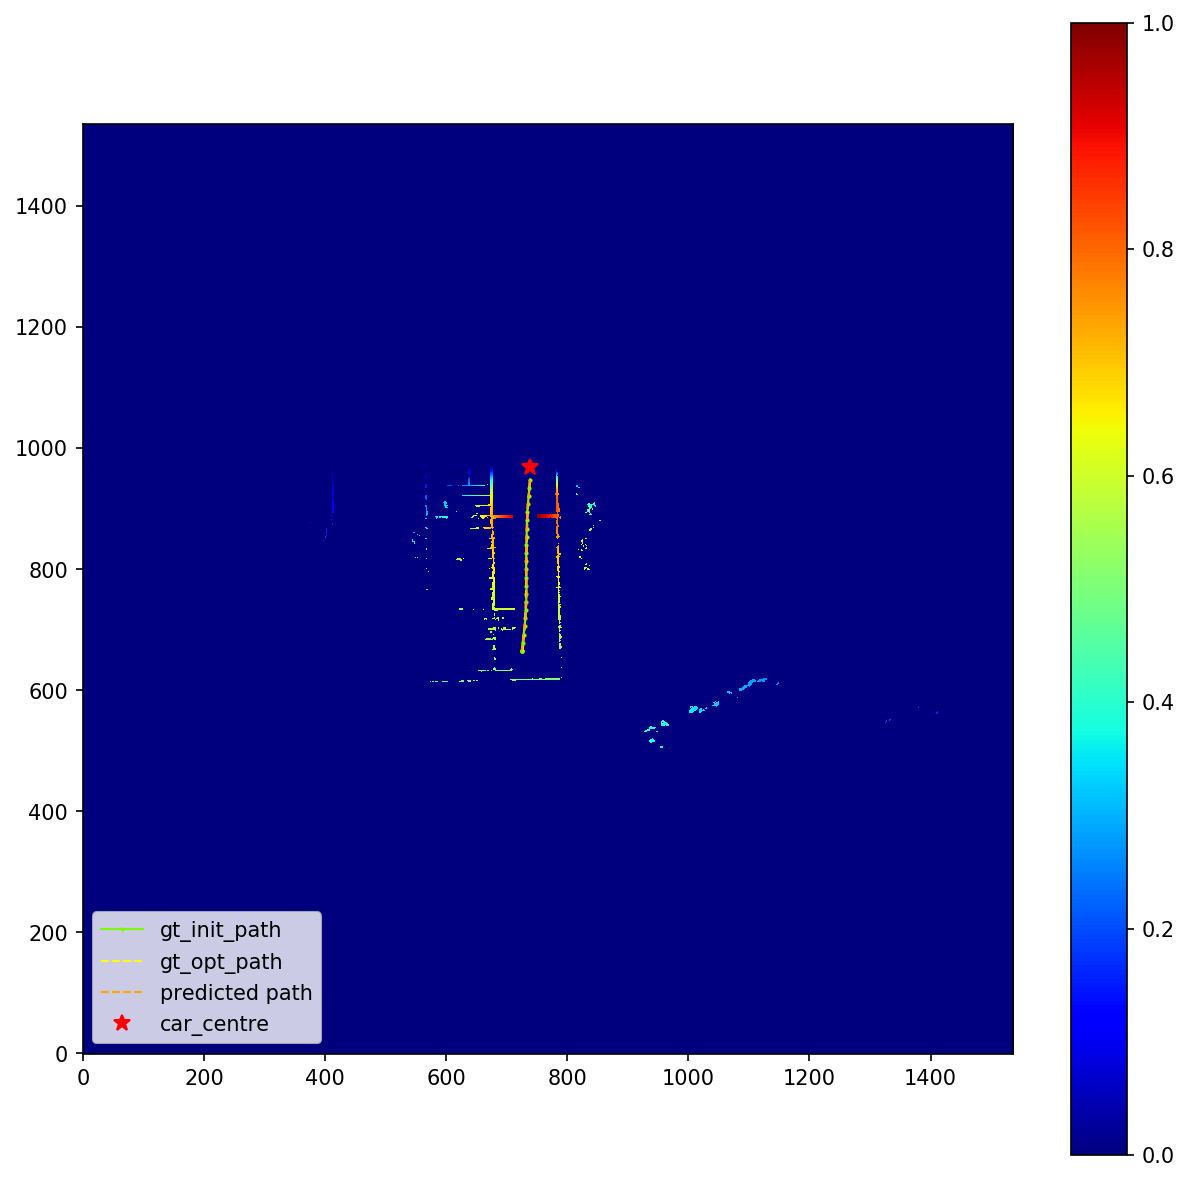

In [60]:
idx=42#48
normalized_factor=1536
plt.figure(figsize=(10,10),dpi=150)
plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)

plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)

plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "r*",
    color="red",
    markersize=8,
)
plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

In [33]:
np.unique(feature_v[idx])

array([0.        , 0.71290618, 0.71312636, 0.71480829, 0.71503329,
       0.95530903, 0.95803839, 0.959777  , 0.96061206, 0.96258861,
       0.9625892 , 0.96302629, 0.96430153, 0.96444339, 0.96524209,
       0.96527755, 0.96612984, 0.96719986, 0.9673624 , 0.96764505,
       0.96773171, 0.96888351, 0.96898663, 0.9692775 , 0.96993512,
       0.97005433, 0.9701522 , 0.97101992, 0.97113955, 0.97187138,
       0.97194684, 0.97220635, 0.97250319, 0.97257239, 0.97258663,
       0.97301465, 0.97352374, 0.97397506, 0.97418433, 0.9746924 ,
       0.97490013, 0.97518265, 0.97598505, 0.9762072 , 0.97660482,
       0.97704673, 0.97712213, 0.97734213, 0.97760546, 0.97769934,
       0.97816366, 0.97822315, 0.97904271, 0.97916561, 0.97951502,
       0.97981644, 0.98029423, 0.98102707, 0.98135763, 0.98140121,
       0.98211133, 0.98223078, 0.98224974, 0.98270345, 0.98291183,
       0.98339909, 0.98369133, 0.98419166, 0.98422301, 0.98480463,
       0.98548901, 0.98614788, 0.98659295, 0.98717552, 0.98750

In [31]:
for i in range(init_path.shape[0]):
    print(np.allclose(init_path[i],opt_path[i],rtol=1e-05, atol=1e-07))

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [16]:
def plot_scene(features,normalized_coords:bool=True,normalized_factor = 1,idx = 1):    
    cost_map = features["cost_map"][idx].astype(float)
    #grid_org = features["grid_org_res"] #[x,y,resolution]
    #left_bnd = features["left_bnd"]
    #right_bnd = features["right_bnd"]
    init_path = features["init_path"][idx].astype(float)
    opt_path = features["opt_path"][idx].astype(float)
    car_odo = features["car_odo"][idx].astype(float)

    #predict_path = features["predictions"]
    file_details=features["file_details"]

    #print(type(grid_map))
    
    plt.figure(figsize=(10, 10))
    #ax=fig.add_subplot(1,1,1)
    if normalized_coords:
            plt.plot(
                init_path[:, 0]*normalized_factor,
                init_path[:, 1]*normalized_factor,
                "o-",
                color="lawngreen",
                markersize=1,
                linewidth=1,
            )
            plt.plot(
                opt_path[:, 0]*normalized_factor,
                opt_path[:, 1]*normalized_factor,
                "--",
                color="yellow",
                markersize=1,
                linewidth=1,
            )

            plt.plot(
                car_odo[0]*normalized_factor,
                car_odo[1]*normalized_factor,
                "r*",
                color="red",
                markersize=8,
            )

            """
            plt.plot(
                predict_path[:, 0]*normalized_factor,
                predict_path[:, 1]*normalized_factor,
                "--",
                color="orange",
                markersize=1,
                linewidth=1,
            )
            """
 

    #plt.legend(['Left bound', 'gt_init_path', 'gt_opt_path','predicted_path','right bound', 'car_centre'], loc='lower left')

    #plt.imshow(cost_map,origin="lower",cmap='jet')

    

    plt.title(f"{file_details}\nTest Index: {idx}")

In [ ]:
plot_scene(features=np_test_ds_all,normalized_coords=True,normalized_factor=1,idx=1)